<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate adversarial training using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate adversarial training using ART on the MNIST dataset.


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import h5py

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

<a id="classifier"></a>
## 2. Train and evaluate a baseline classifier

Load the classifier model:

In [4]:
path = get_file('mnist_cnn_original.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

2023-09-19 14:31:01.288987: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-19 14:31:01.295803: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/kernel/Assign' id:91 op device:{requested: '', assigned: ''} def:{{{node dense_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1/kernel, dense_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-19 14:31:01.359120: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_1/kernel/m/Assign' id:252 op device:{requested: '', assigned: ''} def:{{{node conv2d_1/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_1/kernel/m, conv2d_

In [5]:
# classifier_model = Sequential()
# classifier_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation="relu", input_shape=(28, 28, 1)))
# classifier_model.add(MaxPooling2D(pool_size=(2, 2)))
# classifier_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation="relu", input_shape=(23, 23, 4)))
# classifier_model.add(MaxPooling2D(pool_size=(2, 2)))
# classifier_model.add(Flatten())
# classifier_model.add(Dense(128, activation="relu"))
# classifier_model.add(Dense(10, activation="softmax"))

# classifier_model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

# classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False)

# classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

# classifier.model.save("./mnist_cnn_original.h5")

In [6]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

Evaluate the classifier performance on the first 100 original test samples:

In [7]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_pred))

2023-09-19 14:31:01.457593: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_1/Softmax' id:102 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Original test data:
Correctly classified: 9842
Incorrectly classified: 158


Generate some adversarial samples:

In [8]:
attacker = FastGradientMethod(classifier, eps=0.5)
x_test_adv = attacker.generate(x_test, y_test)

And evaluate performance on those:

In [9]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test, axis=1))

print("Adversarial test data:")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(len(x_test_adv)-nb_correct_adv_pred))

Adversarial test data:
Correctly classified: 31
Incorrectly classified: 9969


<a id="adv_training"></a>
## 3. Adversarially train a robust classifier

In [10]:
path = get_file('mnist_cnn_robust.h5', extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)

2023-09-19 14:31:06.507905: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/bias/Assign' id:573 op device:{requested: '', assigned: ''} def:{{{node dense_3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3/bias, dense_3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-09-19 14:31:06.591307: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_2/kernel/m/Assign' id:717 op device:{requested: '', assigned: ''} def:{{{node conv2d_2/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_2/kernel/m, conv2d_2/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error i

In [11]:
# robust_classifier_model = Sequential()
# robust_classifier_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation="relu", input_shape=(28, 28, 1)))
# robust_classifier_model.add(MaxPooling2D(pool_size=(2, 2)))
# robust_classifier_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, activation="relu", input_shape=(23, 23, 4)))
# robust_classifier_model.add(MaxPooling2D(pool_size=(2, 2)))
# robust_classifier_model.add(Flatten())
# robust_classifier_model.add(Dense(1024, activation="relu"))
# robust_classifier_model.add(Dense(10, activation="softmax"))

# robust_classifier_model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [12]:
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_classifier_model, use_logits=False)

Note: the robust classifier has the same architecture as above, except the first dense layer has **1024** instead of **128** units. (This was recommend by Madry et al. (2017), *Towards Deep Learning Models Resistant to Adversarial Attacks*)

In [13]:
robust_classifier_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)             

Also as recommended by Madry et al., we use BIM/PGD attacks during adversarial training:

In [14]:
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

Perform adversarial training:

In [15]:
# We had performed this before, starting with a randomly initialized model.
# Adversarial training takes about 20 minutes on an NVIDIA A100.
# The resulting model is the one loaded from mnist_cnn_robust.h5 above.

# Here is the command we had used for the Adversarial Training

# trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
# trainer.fit(x_train, y_train, nb_epochs=10, batch_size=128)

# trainer.classifier.model.save("./mnist_cnn_robust.h5")

<a id="evaluation"></a>
## 4. Evaluate the robust classifier

Evaluate the robust classifier's performance on the original test data:

In [16]:
x_test_robust_pred = np.argmax(robust_classifier.predict(x_test), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(nb_correct_robust_pred))
print("Incorrectly classified: {}".format(len(x_test)-nb_correct_robust_pred))

2023-09-19 14:31:06.717139: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_3/Softmax' id:579 op device:{requested: '', assigned: ''} def:{{{node dense_3/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Original test data:
Correctly classified: 9736
Incorrectly classified: 264


Evaluate the robust classifier's performance on the adversarial test data (**white-box** setting):

In [17]:
attacker_robust = FastGradientMethod(robust_classifier, eps=0.5)
x_test_adv_robust = attacker_robust.generate(x_test, y_test)

In [18]:
x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test, axis=1))

print("Adversarial test data:")
print("Correctly classified: {}".format(nb_correct_adv_robust_pred))
print("Incorrectly classified: {}".format(len(x_test_adv_robust)-nb_correct_adv_robust_pred))

Adversarial test data:
Correctly classified: 1382
Incorrectly classified: 8618


In [19]:
attacker_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.5, eps_step=0.01, max_iter=200, verbose=False)
attacker_robust_pgd = ProjectedGradientDescent(estimator=robust_classifier, eps=0.5, eps_step=0.01, max_iter=200, verbose=False)

Compare the performance of the original and the robust classifier over a range of `eps` values:

In [20]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nb_correct_original = []
nb_correct_robust = []

nb_samples = 100

for eps in eps_range:
    attacker_pgd.set_params(**{'eps': eps})
    attacker_robust_pgd.set_params(**{'eps': eps})
    x_test_adv = attacker_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])
    x_test_adv_robust = attacker_robust_pgd.generate(x_test[:nb_samples], y_test[:nb_samples])
    
    x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]
    
    x_test_adv_robust_pred = np.argmax(robust_classifier.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test[:nb_samples], axis=1)) / nb_samples]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred / 10000] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred / 10000] + nb_correct_robust

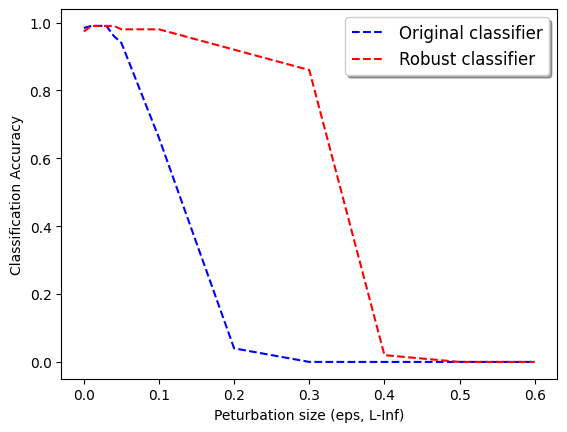

In [21]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper right', shadow=True, fontsize='large')

plt.xlabel('Peturbation size (eps, L-Inf)')
plt.ylabel('Classification Accuracy')
plt.show()